### 9-bus test system
 Definition of the initial 9-bus test system (originally presented in Paul M. Anderson; A. A. Fouad, "Power System Control and Stability" , IEEE, 2003, pp.i-xiv, doi: 10.1109/9780470545577.fmatter.)

### First time this should be run in terminal: 
Install libraries (if  you use uv add dependencies are added to pyproject.toml automatically, if you use uv pip install you need to add manually)

In [ ]:
# Create venv
uv venv
# Activate it
.\.venv\Scripts\activate
# Install packages in the venv
uv add highspy pyscipopt matplotlib pandas numpy cartopy
uv add jupyter
uv add pypsa

Comments:
I ran this in Visual Studio code and had to make two changes to default set up:
1) (rookie mistake): I had all the repos in a one-drive folder, which caused some issues, so i moved everything to a folder not in one-drive
2) Visual studio code has powershell as default terminal (at least in my setup) which was not permitted to activate the vevn. Just changing to command prompt solved this...

### Importing and defining models

In [1]:
import pypsa
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd


In [105]:
#to plot the network this is called within the create_9_bus_network if plot=True
#using first snapshot values 
def plot_network(n):
    plt.figure(figsize=(12, 8))
    # Plot base network
    n.plot(
        bus_sizes=0.01,          
        line_widths=2,          
        bus_colors='red',       
        line_colors='blue',     
        title="IEEE 9-bus System",
        margin=0.15,            
        geomap=False           
    )

    # Add bus labels with nominal voltage
    for bus in n.buses.index:
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        v_nom = n.buses.v_nom[bus]
        bus_type = n.buses.type[bus]
        plt.annotate(
            f"Bus {bus}\n{v_nom}kV\n{bus_type}",
            xy=(x, y),
            xytext=(10, 20),
            textcoords='offset points',
            bbox=dict(facecolor='white', alpha=0.7),
            fontsize=8
        )

    # Add generator labels with setpoints
    for gen in n.generators.index:
        bus = n.generators.bus[gen]
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        # Access first snapshot of p_set time series
        p_set = n.generators_t.p_set[gen].iloc[0]
        p_nom = n.generators.p_nom[gen]
        plt.annotate(
            f"Gen {gen}\nP={p_set:.1f}MW\nPmax={p_nom:.1f}MW",
            xy=(x, y),
            xytext=(-75, -30),
            textcoords='offset points',
            color='magenta',
            bbox=dict(facecolor='white', alpha=0.7),
            fontsize=8
        )

    # Add load labels with setpoints
    for load in n.loads.index:
        bus = n.loads.bus[load]
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        p = n.loads_t.p_set.loc[n.snapshots[0],load]
        q = n.loads_t.q_set.loc[n.snapshots[0],load]
        plt.annotate(
            f"Load {load}\nP={p:.1f}MW\nQ={q:.1f}MVAr",
            xy=(x, y),
            xytext=(-60, -30),
            textcoords='offset points',
            color='brown',
            bbox=dict(facecolor='white', alpha=0.7),
            fontsize=8
        )

    plt.grid(True)
    plt.axis('equal')
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='red', label='Buses', 
               markersize=8, linestyle='None'),
        Line2D([0], [0], color='blue', label='Lines/Transformers', 
               linewidth=2),
        Line2D([0], [0], marker='s', color='magenta', label='Generators',
               markersize=8, linestyle='None'),
        Line2D([0], [0], marker='s', color='brown', label='Loads',
               markersize=8, linestyle='None')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.show()


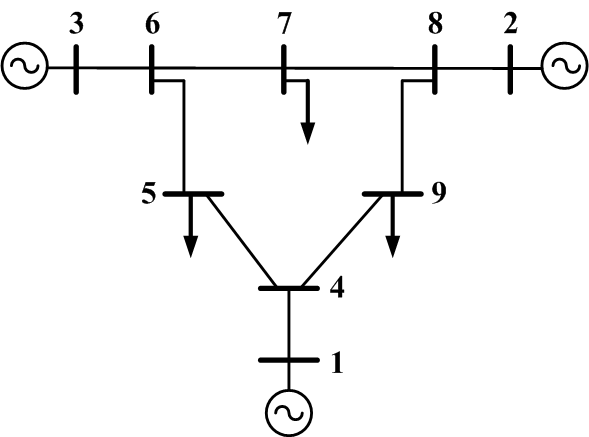

In [112]:
# In the official version generators are connected to bus 1, 2 and 3. 
# This is used as default, but can be changed by specifying bus numbers for each gen.

def create_9_bus_network(gen_bus1=1, gen_bus2=2, gen_bus3=3, plot=False):
    network = pypsa.Network()
    
    # Define five snapshots
    snapshots = pd.date_range("2025-01-01 00:00", periods=5, freq="h")
    network.set_snapshots(snapshots)
    
    # Set base MVA
    network.sbase = 100.0
    
    # IEEE 9-bus layout coordinates
    bus_coordinates = {
        1: (0, 0),      # Generator 1 (slack)
        2: (2, 3),      # Generator 2
        3: (-2, 3),      # Generator 3
        4: (0, 1),     # Load bus
        5: (-1, 2),     # Load bus
        6: (-1, 3),    # Load bus
        7: (0, 3),      # Load bus
        8: (1, 3),      # Load bus
        9: (1, 2)      # Load bus
    }
    
    # Add buses with official IEEE data   
    for i in range(1, 10):
        bus_data = {
            "x": bus_coordinates[i][0],
            "y": bus_coordinates[i][1],
            "v_nom": 230, #if i in [1,2,3] else 230,
            "v_mag_pu_set": 1.04 if i == gen_bus1 else 1.025 if i in [gen_bus2,gen_bus3] else 1.0,
            "v_mag_pu_min": 0.9,
            "v_mag_pu_max": 1.1,
            "type": "Slack" if i == gen_bus1 else "PV" if i in [gen_bus2,gen_bus3] else "PQ"
            }
        network.add("Bus", f"Bus {i}", **bus_data)
        
        # Add loads with oscillating patterns
        if i in [5, 7, 9]:
            # Create base loads to generate varying load patterns
            base_p = {5: 90, 7: 100, 9: 125}[i]
            base_q = {5: 30, 7: 35, 9: 50}[i]
            variation = 0.1  # 10% variation
            #oscilation pattern based on node number
            patterns = {5:np.array([1,0,1,0,-1]),
                        7:np.array([0,1,1,-1,-1]),
                        9: np.array([0,0,1,1,-1])}
            # load is set as base plus/minus a variation of 
            load_p_set = base_p * (1 + variation * patterns[i])  # Oscillating pattern
            load_q_set = base_q * (1 + variation * patterns[i])  # Oscillating pattern
            
            network.add("Load", f"Load {i}", 
                bus=f"Bus {i}",
                p_set=pd.Series(load_p_set, index=snapshots),
                q_set=pd.Series(load_q_set, index=snapshots))
    
    ## Add Generators with official IEEE data
    gen_data = [
    {"bus": f"Bus {gen_bus1}", "p_nom": 247.5, "p_min_pu": 10/247.5, "p_set": pd.Series([0]*5, index=snapshots)},
    {"bus": f"Bus {gen_bus2}", "p_nom": 192.0, "p_min_pu": 10/192.0, "p_set": pd.Series([163]*5, index=snapshots)},
    {"bus": f"Bus {gen_bus3}", "p_nom": 128.0, "p_min_pu": 10/128.0, "p_set": pd.Series([85]*5, index=snapshots)}
    ]
    
    for i, gen in enumerate(gen_data):
        network.add("Generator", f"Gen {i+1}", **gen)
    
    ## Add Lines and Transformers with official IEEE data
    branch_data = [
        # [from_bus, to_bus, r, x, b, s_nom, tap_ratio]
        [1, 4, 0.0000, 0.0576, 0.0000, 250, 1.0],#345/230],  # Transformer 1 (345/230 kV)
        [4, 5, 0.0170, 0.0920, 0.1580, 250, 1.0],      # Line
        [5, 6, 0.0390, 0.1700, 0.3580, 150, 1.0],      # Line
        [3, 6, 0.0000, 0.0586, 0.0000, 300, 1.0],#345/230],  # Transformer 2 (345/230 kV)
        [6, 7, 0.0119, 0.1008, 0.2090, 150, 1.0],      # Line
        [7, 8, 0.0085, 0.0720, 0.1490, 250, 1.0],      # Line
        [8, 2, 0.0000, 0.0625, 0.0000, 250, 1.0],#345/230],  # Transformer 3 (345/230 kV)
        [8, 9, 0.0320, 0.1610, 0.3060, 250, 1.0],      # Line
        [9, 4, 0.0100, 0.0850, 0.1760, 250, 1.0]       # Line
        ]
    
    for i, branch in enumerate(branch_data):
        f_bus, t_bus, r, x, b, rate, tap = branch
        if tap != 1.0:  # Tap not equal to 1 indicates a transformer
            network.add("Transformer", f"Transformer {i+1}",
                    bus0=f"Bus {f_bus}",
                    bus1=f"Bus {t_bus}",
                    r=r,
                    x=x,
                    b=b,
                    s_nom=rate,
                    tap_ratio=tap)
        else:  # Tap equal to 1 indicates normal line (no transformer)
            network.add("Line", f"Line {i+1}",
                    bus0=f"Bus {f_bus}",
                    bus1=f"Bus {t_bus}",
                    r=r,
                    x=x,
                    b=b,
                    s_nom=rate)
    
    if plot:
        plot_network(network)
    return network

### Running power flow simulations


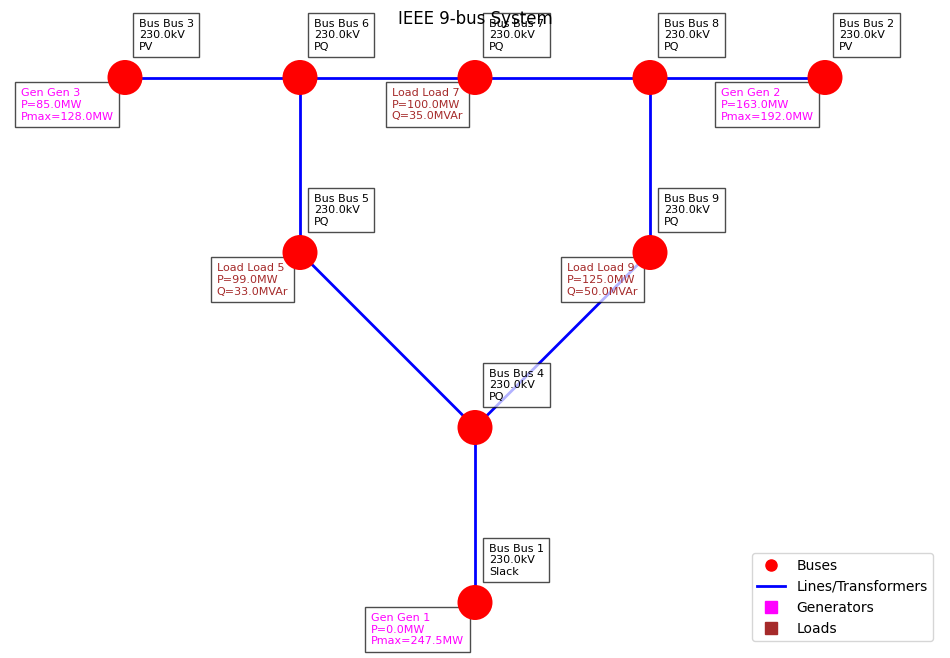

In [113]:
n = create_9_bus_network(plot=True) # create the network with some parameters

In [ ]:
ne

In [123]:
def model_results(n, print_results=False):
    n.lpf()
    n.pf(use_seed=True)
    # Create DataFrame with bus results for all snapshots
    results_df = pd.DataFrame(
        index=n.snapshots,
        columns=pd.MultiIndex.from_product([
            n.buses.index,
            ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']
        ])
    )

    # Fill results for each snapshot
    for t in n.snapshots:
        for bus in n.buses.index:
            results_df.loc[t, (bus, 'P (MW)')] = n.buses_t.p.loc[t, bus]
            results_df.loc[t, (bus, 'Q (MVAr)')] = n.buses_t.q.loc[t, bus]
            results_df.loc[t, (bus, 'V (pu)')] = n.buses_t.v_mag_pu.loc[t, bus]
            results_df.loc[t, (bus, 'Angle (deg)')] = n.buses_t.v_ang.loc[t, bus]

    if print_results:
        print("\nBus Results:") 
        print(results_df)
        #for s in results_df.index:
        #    print(results_df.loc[s])

    return results_df


In [124]:
# some issues with non converging results. probaly due to transformers (or possibly varying loads, Need to check more later... 
df=model_results(n,print_results=True) # run the power flow and store results in df. Print if print_results = True

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2025-01-01 00:00:00', '2025-01-01 01:00:00',
               '2025-01-01 02:00:00', '2025-01-01 03:00:00',
               '2025-01-01 04:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq='h')
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2025-01-01 00:00:00', '2025-01-01 01:00:00',
               '2025-01-01 02:00:00', '2025-01-01 03:00:00',
               '2025-01-01 04:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq='h')
INFO:pypsa.pf:Newton-Raphson solved in 5 iterations with error of 0.000000 in 0.022110 seconds
INFO:pypsa.pf:Newton-Raphson solved in 5 iterations with error of 0.000000 in 0.022233 seconds
INFO:pypsa.pf:Newton-Raphson solved in 5 iterations with error of 0.000000 in 0.021326 seconds
INFO:pypsa.pf:Newton-Raphson solved in 5 iterations with error of 0.000000 in 0.020


Bus Results:
Bus                        Bus 1                                   Bus 2  \
                          P (MW)      Q (MVAr) V (pu) Angle (deg) P (MW)   
snapshot                                                                   
2025-01-01 00:00:00  1594.875625   -91774.4542   1.04         0.0  163.0   
2025-01-01 01:00:00   1595.76829 -91773.689533   1.04         0.0  163.0   
2025-01-01 02:00:00  1617.100015 -91765.236317   1.04         0.0  163.0   
2025-01-01 03:00:00  1588.539186 -91776.424038   1.04         0.0  163.0   
2025-01-01 04:00:00  1554.801133  -91790.10668   1.04         0.0  163.0   

Bus                                                 Bus 3           ...  \
                    Q (MVAr)    V (pu) Angle (deg) P (MW) Q (MVAr)  ...   
snapshot                                                            ...   
2025-01-01 00:00:00      0.0   1.27161   -0.022457   85.0      0.0  ...   
2025-01-01 01:00:00      0.0  1.271601   -0.022469   85.0      0.0  ...   
20

In [44]:
now = n.snapshots[0]

angle_diff = pd.Series(n.buses_t.v_ang.loc[now,n.lines.bus0].values -
                       n.buses_t.v_ang.loc[now,n.lines.bus1].values,
                       index=n.lines.index)

(angle_diff*180/np.pi).describe()

count    6.000000e+00
mean    -7.228014e-20
std      9.207527e-03
min     -1.146165e-02
25%     -5.421409e-03
50%     -5.647434e-04
75%      3.367520e-03
max      1.495316e-02
dtype: float64